In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.ticker import MaxNLocator

csv_file_path = '/content/gdrive/MyDrive/processati_email/chunked_userID'

df_anagrafici_excel = pd.read_excel(io = "/content/gdrive/MyDrive/Colab Notebooks/Dati per POLIMI RIVISTO_OUTPUT.xlsx", engine='openpyxl', sheet_name= 'OUTPUT')


id_email_unique=[]
for filename in os.listdir(csv_file_path):
    if filename.endswith(".csv"):

        # Extract the user_id from the filename by removing the ".csv" extension
        ID_persona = filename[:-4]
        id_email_unique.append(ID_persona)


## This dataframe DON'T CONTAIN OUTLIERS (according to Gabriele)
df_survey = pd.read_excel(io = "/content/gdrive/MyDrive/Colab Notebooks/JRC_Credem_Survey.xlsx", engine='openpyxl', sheet_name= 'Dataset_nooutlier') #1495 utenti

column_data_types = {
    'CODICI RISPONDENTI': str,
    'SCALA 100': float
}
df_retribuzione_excel = pd.read_excel(io = "/content/gdrive/MyDrive/Colab Notebooks/Dataset_retribuzione scala 100_OUTPUT.xlsx", engine='openpyxl', sheet_name='PANEL RETR SCALA 100 OUTPUT', dtype=column_data_types)


df_features = pd.read_csv('/content/gdrive/MyDrive/processati_email/df_features2.csv')


# vado ad utilizzare le aggregazioni suggerite da Enrica
mapping1 = {
        'EBDCFA':'BE',
        'EBDPBK':'BE',
        'EBDRPF':'BE',
        'EUROBA':'BE',

        'EUROFO':'SGR',
        'SGRCCE':'SGR',
        'SGRDBL':'SGR',
        'SGRINV':'SGR',

        'PRIVAT':'CENTRO PRIVATE CREDEM',
        'COPRIV':'CENTRO PRIVATE CREDEM',

        'RP01':'DRC',

        'CSDIR': 'CDMASS',

        'CVDIR': 'CDMVIT',

        'VDGPM':'STAFF DIREZIONE',
        'DIRGEN':'STAFF DIREZIONE',

        'VDGBC':'COMME'
        }
df_features['BU_sup'] = df_features['BU_sup'].replace(mapping1)



mapping2 = {
        'Addetto': 0,
        'Manager': 1
        }

df_features['addettoVSmanager'] = df_features['addettoVSmanager'].replace(mapping2)

print("persone in anagragica: ", df_anagrafici_excel['CODICI RISPONDENTI'].nunique() )
print("persone nella survey: ", df_survey['PASSWORD'].nunique() )
print("persone in retribuzione: ", df_retribuzione_excel['CODICI RISPONDENTI'].nunique() )
print("persone nelle email: ", len(id_email_unique) )
print("persone nelle feature: ", len(df_features) )




persone in anagragica:  2041
persone nella survey:  1495
persone in retribuzione:  2041
persone nelle email:  2041
persone nelle feature:  2041


In [ ]:

#//////////////////////////////  INGESTION SURVEY \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\

## This dataframe CONTAINS OUTLIERS (according to Gabriele)
#df_survey = pd.read_excel(io = "JRC_Credem_Survey.xlsx", engine='openpyxl', sheet_name= 'Dataset (2)') # 1651 utenti



#////////////////////  CALCOLO VARIBILI MEDIA COSTRUTTI SURVEY \\\\\\\\\\\\\\\\\\\\\\\\\\\\\

#print(df_survey['PASSWORD'].nunique()) ##1651 id nella survey

WE_columns = ['WE_1', 'WE_2', 'WE_3', 'WE_4', 'WE_5', 'WE_6', 'WE_7', 'WE_8', 'WE_9']
JS_columns = ['JS_1', 'JS_2', 'JS_3', 'JS_4', 'JS_5', 'JS_6']
AOC_columns = ['AOC_1', 'AOC_2', 'AOC_3', 'AOC_4', 'AOC_5', 'AOC_6', 'AOC_7', 'AOC_8']
OJ_columns = ['OJ_1', 'OJ_2', 'OJ_3', 'OJ_4', 'OJ_5', 'OJ_6', 'OJ_7', 'OJ_8', 'OJ_9', 'OJ_10', 'OJ_11', 'OJ_12', 'OJ_13', 'OJ_14', 'OJ_15', 'OJ_16', 'OJ_17', 'OJ_18', 'OJ_19', 'OJ_20']
MT_columns = ['MT_1', 'MT_2', 'MT_3', 'MT_4', 'MT_5'] # here there where MT_5_r, so I applied a change (old:new): 1:7, 2:6, 3:5, 4:4, 5:3, 6:2, 7:1
EQ_columns = ['EQ_1', 'EQ_2', 'EQ_3', 'EQ_4', 'EQ_5', 'EQ_6', 'EQ_7', 'EQ_8']

# Compute the average of the nine columns for each user
df_survey['WE_average'] = df_survey[WE_columns].mean(axis=1)
df_survey['JS_average'] = df_survey[JS_columns].mean(axis=1)
df_survey['AOC_average'] = df_survey[AOC_columns].mean(axis=1)
df_survey['OJ_average'] = df_survey[OJ_columns].mean(axis=1)
df_survey['MT_average'] = df_survey[MT_columns].mean(axis=1)
df_survey['EQ_average'] = df_survey[EQ_columns].mean(axis=1)

# I create a dataframe that contains only the PASSWORD and average columns
sub_df_survey = df_survey.loc[:, ['PASSWORD','Età', 'Sesso' , 'WE_average', 'JS_average', 'AOC_average', 'OJ_average', 'MT_average', 'EQ_average']]



In [ ]:

import networkx as nx

#////////////////////////////////////////////////////////// CREIAMO LA NETWORK \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\


## GRAFO DIRETTO, PESATO E PULITO (tolgo i vari: ND, Group, External, Consulenti)

G_directed_weighted_new = nx.MultiDiGraph()
processato=0

for filename in os.listdir(csv_file_path):
      if filename.endswith(".csv"):


          # Extract the user_id from the filename by removing the ".csv" extension
          ID_persona = filename[:-4]

          # Read the CSV file into a DataFrame
          csv_file = os.path.join(csv_file_path, filename)
          df_email_completo = pd.read_csv(csv_file)

          processato= processato+1
          if processato%100==0 : print(processato)
          if ((ID_persona=='External') or  (ID_persona=='Consulenti') or  (ID_persona=='ND')or  (ID_persona=='Group')): continue



          # Filtrare le email inviate da ID_persona
          email_inviate = df_email_completo[df_email_completo['source_from_header_address'] == ID_persona]

          for i, row in email_inviate.iterrows():
              source = row['source_from_header_address']
              dest = row['destination_address']
              if G_directed_weighted_new.has_edge(source, dest):
                  G_directed_weighted_new[source][dest][0]['weight'] = G_directed_weighted_new[source][dest][0]['weight'] + 1
              else:
                  G_directed_weighted_new.add_edge(source, dest, weight=1)



100
200


<ipython-input-4-d7debe40b464>:20: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_email_completo = pd.read_csv(csv_file)


300
400
500
600
700
800
900
1000
1100
1200
1300


<ipython-input-4-d7debe40b464>:20: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_email_completo = pd.read_csv(csv_file)


1400
1500
1600
1700
1800
1900
2000


In [ ]:
numero_nodi = nx.number_of_nodes(G_directed_weighted_new)

print("Numero di nodi nel grafo:", numero_nodi)

Numero di nodi nel grafo: 2027


In [ ]:

# controllo se il grafo è totalmente connesso, questo mi serve per calcolare le metriche di centralità
# il grafo smette di essere connesso quando elimino i nodi: EXTERNAL e CONSULENTI,
# quindi potrebbe essere che ci sono delle persone in particolare che scrivono a queste entità: come mai però nessuno scrive a queste perosne??

is_strongly_connected = nx.is_strongly_connected(G_directed_weighted_new)
is_weakly_connected = nx.is_weakly_connected(G_directed_weighted_new)

if is_strongly_connected:
    print("The graph is strongly connected: there is a directed path between every pair of nodes.")
elif is_weakly_connected:
    print("The graph is weakly connected: meaning that the underlying undirected graph is connected.")
else:
    print("The graph is not fully connected.")




In [ ]:


#tolgo i vari: ND, Group, External, Consulenti, perché tanto le feature di chi scrive a loro le ho già calcolate
# e nel grafo questi nodi mi vanno a sballare le metriche di centralità perché creano degli shortest path
# e quasi tutte le metriche di centralità sono basate sugli shortest path!!!!

for node in ['ND', 'External', 'Consulenti', 'Group']:
    if node in G_directed_weighted_new.nodes:
        G_directed_weighted_new.remove_node(node)
    else:
        # se ho eseguito correttamente il cleaning dei dati prima di creare la network:
        # i nodi [Group, ND] NON devono comparire e quindi non c'è bisogno di toglierli
        print(f"Node '{node}' is not present in the network.")



Node 'Group' is not present in the network.


In [ ]:

"""
When calculating the shortest paths between nodes N1 and N2,
the edge weights are taken into account by using a modified version of Dijkstra's algorithm
called the "weighted shortest path algorithm".
This algorithm finds the shortest path between two nodes
by minimizing the sum of the weights of the edges along the path, in other words it consider the value on the edge as a distance instead of a strength.

So we need to transform all the weights on the edges to their reciprocal so that we have a strength instead of a distance.
So that the higher is the amount of email exchanged between two nodes,
"the lower it is the weight", since it is at the denominator,
for example, if two nodes have exchanged only 1 email, the weight on the edge will be 1/1=1,
while if two nodes have exchanged 5 emails it will be: 1/5=0.2 ,
and since the metrics tries to minimize the sum of the weight, 0.2 will represent a stronger relationship than 1
"""
for n1,n2 in G_directed_weighted_new.edges():
    G_directed_weighted_new[n1][n2][0]['weight'] = 1/G_directed_weighted_new[n1][n2][0]['weight']


In [ ]:

# printo la lista delle persone che non sono collegate a nessuno, è strano che non siano collegate....

isolated_nodes = list(nx.isolates(G_directed_weighted_new))
print("Isolated nodes:", len(isolated_nodes) , ' , lista: ', isolated_nodes)
print()


for node_id in isolated_nodes:
    if node_id in G_directed_weighted_new.nodes:
        in_degree = G_directed_weighted_new.in_degree(node_id)
        out_degree = G_directed_weighted_new.out_degree(node_id)
        print("Node:", node_id, " Posizione:", df_features.loc[ df_features['user_ID']==node_id  , 'addettoVSmanager' ].values[0] , " In-degree:", in_degree, " Out-degree:", out_degree)
    else:
        print("Node not found in the network.")


# magari sono semplicemente delle persone che hanno lavorato per poco tempo all'interno dell'azienda,
# valuta nuovamente questa cosa quando eseguirai il codice su tutto il dataset, in teoria non dovrebbero esserci persone isolate,
# e se ci sono possono essere al massimo poche


Isolated nodes: 0  , lista:  []



In [ ]:
"""
Vado a salvare la network per fare l'ingestion dentro neo4j
"""
"""
from networkx.readwrite import json_graph
import json

data = json_graph.node_link_data(G_directed_weighted_new)

# Specifica il percorso (path) del file JSON in cui salvare i dati della rete
file_path = '/content/gdrive/MyDrive/processati_email/NetworkSalvata/networkDirected1.json'

# Salvataggio dei dati della rete su un file JSON
with open(file_path, 'w') as file:
    json.dump(data, file)
"""

In [ ]:

# vado a droppare le persone isolate, non mi interessano, non comunicano con nessuno, non ho modo di estrarre nessuna feature inerernte al loro comportamento comunicativo

for node in isolated_nodes:
    if node in G_directed_weighted_new.nodes:
        G_directed_weighted_new.remove_node(node)
    else:
        # se ho eseguito correttamente il cleaning dei dati prima di creare la network:
        # i nodi [Group, ND] NON devono comparire e quindi non c'è bisogno di toglierli
        print(f"Node '{node}' is not present in the network.")




In [ ]:

#//////////////////////////////////// METRICHE DI CENTRALITA' \\\\\\\\\\\\\\\\\\\\\\\\\\\\

# Documentazione ufficiale: https://networkx.org/documentation/stable/reference/algorithms/centrality.html

# IN-DEGREE CENTRALITY: the fraction of nodes its incoming edges are connected to
# NORMALIZED: The degree centrality values are normalized by dividing by the maximum possible degree in a simple graph n-1 where n is the number of nodes in G.
# because of the normalization, the values ranges from 0 to 1
in_degree_centrality = nx.in_degree_centrality(G_directed_weighted_new)

# OUT-DEGREE CENTRALITY: the fraction of nodes its outgoing edges are connected to.
# NORMALIZED: The degree centrality values are normalized by dividing by the maximum possible degree in a simple graph n-1 where n is the number of nodes in G.
# because of the normalization, the values ranges from 0 to 1
out_degree_centrality = nx.out_degree_centrality(G_directed_weighted_new)

# BETWEENNESS CENTRALITY: is the sum of the fraction of all-pairs shortest paths that pass through
# NORMALIZED: If True the betweenness values are normalized by 2/((n-1)(n-2)) for graphs, and 1/((n-1)(n-2)) for directed graphs where n is the number of nodes in G.
# so because of the normalization, the values ranges from 0 to 1
# WEIGHT: Weights are used to calculate weighted shortest paths, so they are interpreted as distances.
betweenness_centrality_weight = nx.betweenness_centrality(G_directed_weighted_new, normalized=True, weight='weight')

#PAGE RANK
# Calculate Influence Index based on page rank
#NORMALIZED: already from 0 to 1
page_Rank = nx.pagerank(G_directed_weighted_new, alpha=0.85, personalization=None, max_iter=100, tol=0.001)


# CLOSENESS CENTRALITY: is the reciprocal of the average shortest path distance to u over all n-1 reachable nodes.
# NORMALIZED: The closeness centrality is normalized to (n-1)/(|G|-1) where n is the number of nodes in the connected part of graph containing the node + plus dividing by the maximum to scale between 0 and 1
closeness_centrality_weight = nx.closeness_centrality(G_directed_weighted_new, distance='weight')



# CONTRIBUTION INDEX
# NORMALIZED: at the denominator we are subtracting by the total of the email sent, so it is already normalized from 0 to 1
## since networkX doesn't implement the "contribution index", I calculated it manually
## CI= (#messages_sent - #messages_received) / (#messages_sent + #messages_received)

# calcolo il CI direttamente dopo!




In [ ]:
numero_nodi = nx.number_of_nodes(G_directed_weighted_new)

In [ ]:

# IN-DEGREE CENTRALITY
df_idUser_in_degree_centrality_new = pd.DataFrame(columns=['idUser', 'in_degree_DIR'])

for idUser, value in in_degree_centrality.items():
    row = {'idUser': idUser, 'in_degree_DIR': value}
    df_idUser_in_degree_centrality_new = pd.concat([df_idUser_in_degree_centrality_new, pd.DataFrame([row])], ignore_index=True)


# OUT-DEGREE CENTRALITY
df_idUser_out_degree_centrality_new = pd.DataFrame(columns=['idUser', 'out_degree_DIR'])

for idUser, value in out_degree_centrality.items():
    row = {'idUser': idUser, 'out_degree_DIR': value}
    df_idUser_out_degree_centrality_new = pd.concat([df_idUser_out_degree_centrality_new, pd.DataFrame([row])], ignore_index=True)


# BETWEENNESS CENTRALITY
df_idUser_betweenness_centrality_weight_new = pd.DataFrame(columns=['idUser', 'betweenness_DIR'])

for idUser, value in betweenness_centrality_weight.items():
    row = {'idUser': idUser, 'betweenness_DIR': value}
    df_idUser_betweenness_centrality_weight_new = pd.concat([df_idUser_betweenness_centrality_weight_new, pd.DataFrame([row])], ignore_index=True)


# CLOSENESS CENTRALITY
df_idUser_closeness_centrality_weight_new = pd.DataFrame(columns=['idUser', 'closeness_DIR'])
max_closeness = max(closeness_centrality_weight.values())

for idUser, value in closeness_centrality_weight.items():
    scaled_value = value / max_closeness
    row = {'idUser': idUser, 'closeness_DIR': scaled_value}
    df_idUser_closeness_centrality_weight_new = pd.concat([df_idUser_closeness_centrality_weight_new, pd.DataFrame([row])], ignore_index=True)


#  PAGE RANK & INFLUENCE INDEX
df_idUser_pageRank = pd.DataFrame(columns=['idUser', 'pageRank', 'influenceIndex'])
max_page_rank = max(page_Rank.values())  # Calcola il massimo valore di PageRank

for idUser, value in page_Rank.items():
    influence_index = value / max_page_rank
    row = {'idUser': idUser, 'pageRank': value, 'influenceIndex': influence_index}
    df_idUser_pageRank = pd.concat([df_idUser_pageRank, pd.DataFrame([row])], ignore_index=True)

# CONTRIBUTION INDEX
df_idUser_CI = pd.DataFrame(columns=['idUser', 'contribution_index'])

for idUser in id_email_unique:
    messages_sent = df_features.loc[df_features['user_ID'] == idUser, 'total_sent_email']
    messages_received = df_features.loc[df_features['user_ID'] == idUser, 'total_received_email']
    ci_user = (messages_sent - messages_received) / (messages_sent + messages_received)

    row = {'idUser': idUser, 'contribution_index': ci_user.values[0]}
    df_idUser_CI = pd.concat([df_idUser_CI, pd.DataFrame([row])], ignore_index=True)


In [ ]:
#!pip install graspologic

In [ ]:

########################################    HIERARCHICAL LEIDEN PARTITION         ##############################################


import graspologic
from graspologic.partition import leiden


undirectedGraph = nx.Graph()

for src, dst, weight in G_directed_weighted_new.edges(data='weight'):
    if undirectedGraph.has_edge(src, dst):
        undirectedGraph[src][dst]['weight'] += weight
    else:
        undirectedGraph.add_edge(src, dst, weight=weight)


# in the context of the Leiden algorithm, the term "weight" typically refers to a measure of the strength or intensity of the connections between nodes in a network,
leidenResult = graspologic.partition.hierarchical_leiden(undirectedGraph, weight_attribute='weight' , max_cluster_size=100, random_seed=63)
leidenClusters = leidenResult.final_level_hierarchical_clustering()


#print(leidenResult)
#print()
#print(leidenClusters)
#print()

# Create a function to map users to community label
def getLabel(x):
    return leidenClusters.get(x)


df_community_bridgeIndex = pd.DataFrame({'src': [node for node in undirectedGraph.nodes()], 'Community': [getLabel(node) for node in undirectedGraph.nodes()]})

# Drop duplicate rows
df_community_bridgeIndex = df_community_bridgeIndex.drop_duplicates()


# Calculate the number of distinct communities
numCommunities = len(set(leidenClusters.values()))

###################
# Counts how many communities C a user is connected to with an out edge (in the sense that given A, I count how many distinct communities are present in the nodes attached to A), normalized by num of communities
# For all users, compute C / (num of Communities)
# 1 = they are connected to all communities
# 0 = they have no connections


# Aggiunta delle etichette "Community" ai nodi nel grafo
for node, community in df_community_bridgeIndex[['src', 'Community']].values:
    undirectedGraph.nodes[node]['Community'] = community

# Funzione per calcolare il numero di nodi con valore diverso in 'Community' a cui è collegato un nodo
def calculate_distinct_community_count(node):
    neighbors = list(undirectedGraph.neighbors(node))
    distinct_community_neighbors = set([getLabel(neighbor) for neighbor in neighbors if getLabel(neighbor) != getLabel(node)])
    return len(distinct_community_neighbors)

# Calcolo del numero di altri nodi con un valore diverso in 'Community' a cui ciascun nodo è collegato
df_community_bridgeIndex['OtherNodesWithDistinctCommunity'] = df_community_bridgeIndex['src'].apply(calculate_distinct_community_count)


#################

# Calculate the Community Bridging Index
df_community_bridgeIndex['CommunityBridgeIndex'] = df_community_bridgeIndex['OtherNodesWithDistinctCommunity'] / numCommunities

# Create a DataFrame to hold the interaction matrix
interactionMatrix = pd.pivot_table(df_community_bridgeIndex, index='src', columns='Community', aggfunc='sum', fill_value=0)

# Print the resulting DataFrames or analysis results
print("Community Bridging Index:")
print(df_community_bridgeIndex['CommunityBridgeIndex'].sort_values(ascending=False))
#print("\nInteraction Matrix:")
#print(interactionMatrix)

print()
print("Number of communities:", numCommunities)
print()
print(df_community_bridgeIndex)
print()

pivot_table = df_community_bridgeIndex.pivot_table(index='Community', values='src', aggfunc='count')
print(pivot_table.sort_values(by='src', ascending=False))


Community Bridging Index:
108     0.984127
76      0.984127
154     0.984127
157     0.984127
66      0.968254
          ...   
1836    0.015873
2014    0.000000
2013    0.000000
2024    0.000000
2025    0.000000
Name: CommunityBridgeIndex, Length: 2027, dtype: float64

Number of communities: 63

                         src  Community  OtherNodesWithDistinctCommunity  \
0     zV0F6ND6TqeIuY93nyqIBg          7                               29   
1     iF0_nRrHTJ-SBgai1Ls-Ug          8                               55   
2     50MzSMJTSZyRu7BdV_VdwA          8                               47   
3     qUSFZT0ISGaHkpSNUqAk-A          7                               40   
4     QZ4-q1FyT865hIYxNG9hHA          9                               37   
...                      ...        ...                              ...   
2022  HEDY71yDRo2Ka8b18Uar3A         10                                5   
2023  YE_q2l1zTV66dBd_3vi3qw         14                                8   
2024  Rc4mCTc6TkCD

In [ ]:
#df_community_bridgeIndex.drop("OtherNodesWithDistinctCommunity", axis=1, inplace=True)
#df_community_bridgeIndex

In [ ]:
#/////////////////// DATAFRAME WEIGHTED \\\\\\\\\\\

#because in the survey we have only 1495 people, instead of 2041, so to keep all the data available we do the left join and put all 0's
merged_df_weighted_new = pd.merge(sub_df_survey, df_idUser_in_degree_centrality_new, left_on='PASSWORD', right_on='idUser', how='right').fillna(0)

#Drop the 'password'
#column(axis=1 means 'column', axis=0 means 'row')
merged_df_weighted_new.drop('PASSWORD', axis=1, inplace=True)

merged_df_weighted_new = pd.merge( merged_df_weighted_new, df_idUser_out_degree_centrality_new, on='idUser')
merged_df_weighted_new = pd.merge( merged_df_weighted_new,df_idUser_betweenness_centrality_weight_new, on='idUser')
merged_df_weighted_new = pd.merge( merged_df_weighted_new,df_idUser_closeness_centrality_weight_new, on='idUser')
merged_df_weighted_new = pd.merge( merged_df_weighted_new, df_idUser_pageRank, on='idUser')
merged_df_weighted_new = pd.merge( merged_df_weighted_new,df_idUser_CI, on='idUser')
merged_df_weighted_new = pd.merge( merged_df_weighted_new, df_community_bridgeIndex, left_on='idUser', right_on='src')

merged_df_weighted_new.drop('src', axis=1, inplace=True)


In [ ]:
#//////////////// STATISTICHE SUL DATASET FINALE DELLE FEATURESSSSSSSSSSSSSSSSS\\\\\\\\\\\\\\\\\\\
finale_features = pd.merge( merged_df_weighted_new, df_features, left_on='idUser', right_on='user_ID')
finale_features = finale_features.drop('idUser', axis=1)

print(finale_features.describe().to_string())
print()
print()
#print(finale_features.info())
print()
print()
#print(finale_features.columns)


               Età   WE_average   JS_average  AOC_average   OJ_average   MT_average   EQ_average  in_degree_DIR  out_degree_DIR  betweenness_DIR  closeness_DIR     pageRank  influenceIndex  contribution_index    Community  OtherNodesWithDistinctCommunity  CommunityBridgeIndex  addettoVSmanager  performance    seniority  retribuzione  total_sent_email  total_received_email  #persone_interazioni  sent_to_EXTERNAL  received_from_EXTERNAL  sent_to_CONSULENTI  received_from_CONSULENTI  people_sent_SAME_bu_SUP  email_sent_SAME_bu_SUP  people_sent_SAME_bu_INF  email_sent_SAME_bu_INF  email_sent_different_bu_SUP  people_sent_different_bu_SUP  people_sent_different_bu_INF  email_sent_different_bu_INF  people_received_SAME_bu_SUP  email_received_SAME_bu_SUP  people_received_SAME_bu_INF  email_received_SAME_bu_INF  people_received_DIFFERENT_bu_SUP  email_received_DIFFERENT_bu_SUP  email_received_DIFFERENT_bu_INF  people_received_DIFFERENT_bu_INF  total_SAME_bu_SUP  people_total_SAME_bu_SUP  total

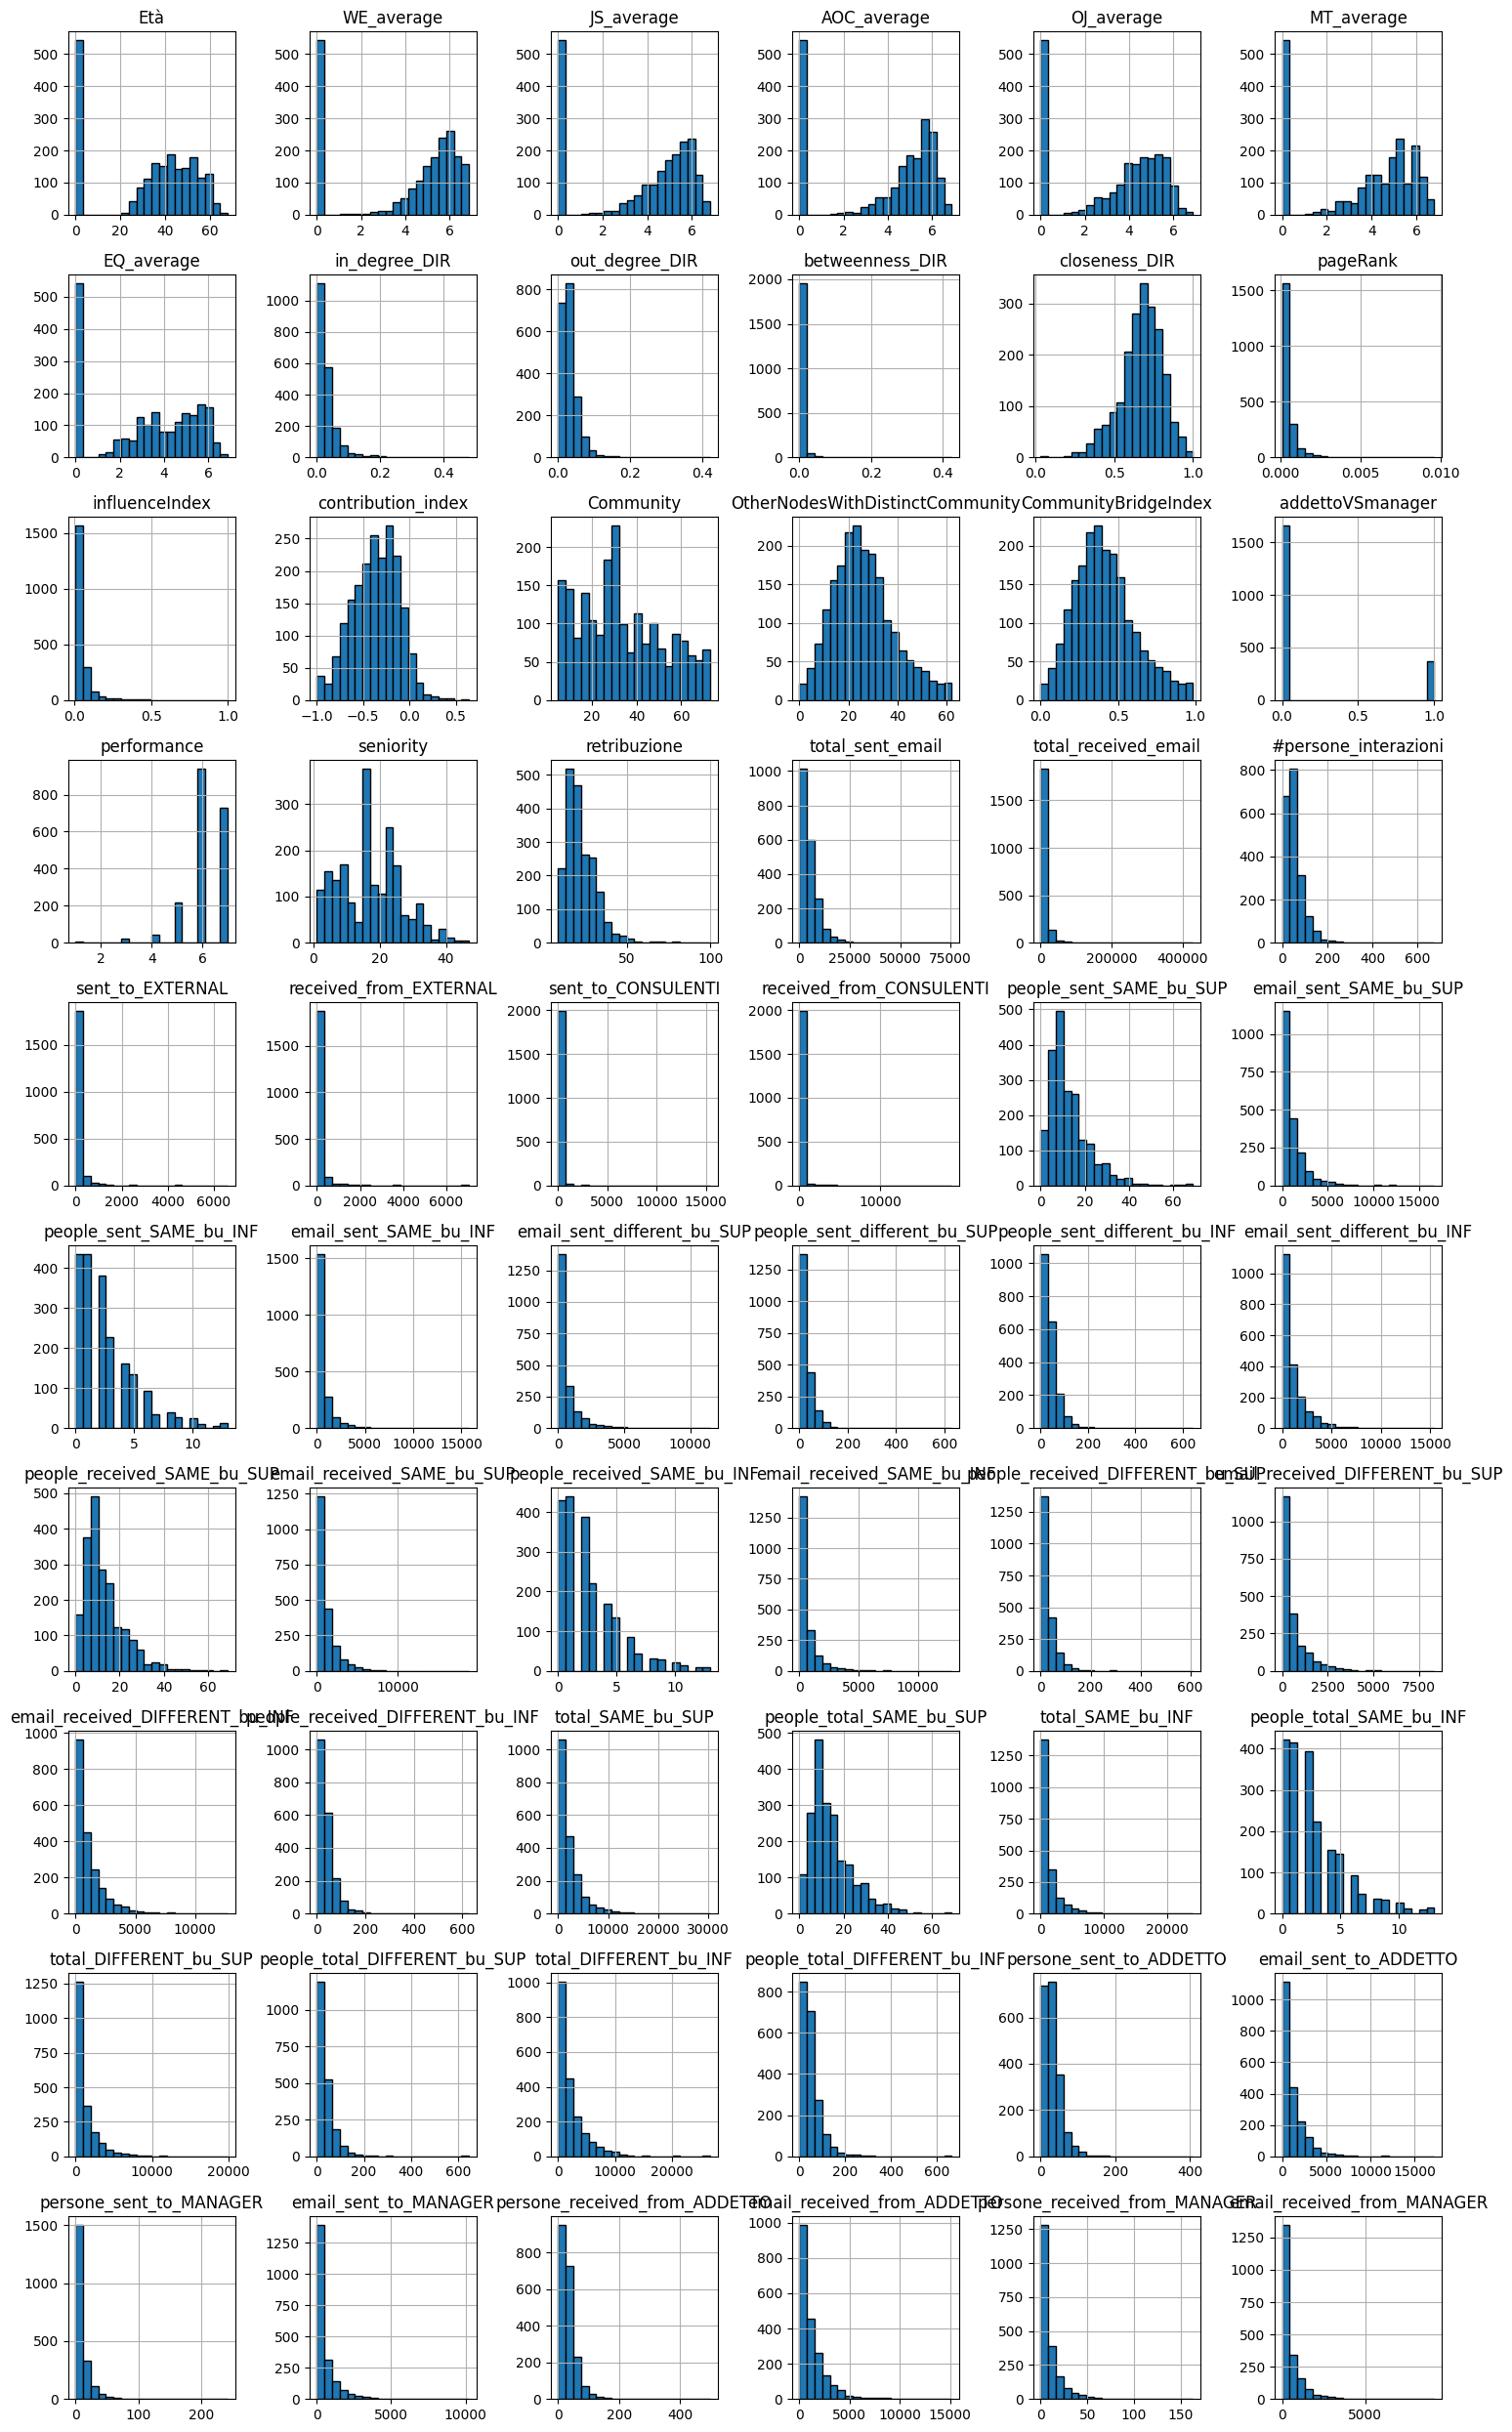

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Supponiamo che 'finale_features' sia il tuo dataframe
# Carica i dati nel dataframe o sostituisci questa riga con il tuo metodo di caricamento dati

# Plotta gli istogrammi con distanza maggiore tra i grafici
finale_features.hist(layout=(10, 6), figsize=(15, 25), bins=20, edgecolor='black')
plt.tight_layout()  # Ottimizza lo spaziamento tra i grafici
plt.show()


<ipython-input-178-214edbf54639>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrice_correlazioni= finale_features[finale_features['WE_average']!=0].corr()


<Axes: >

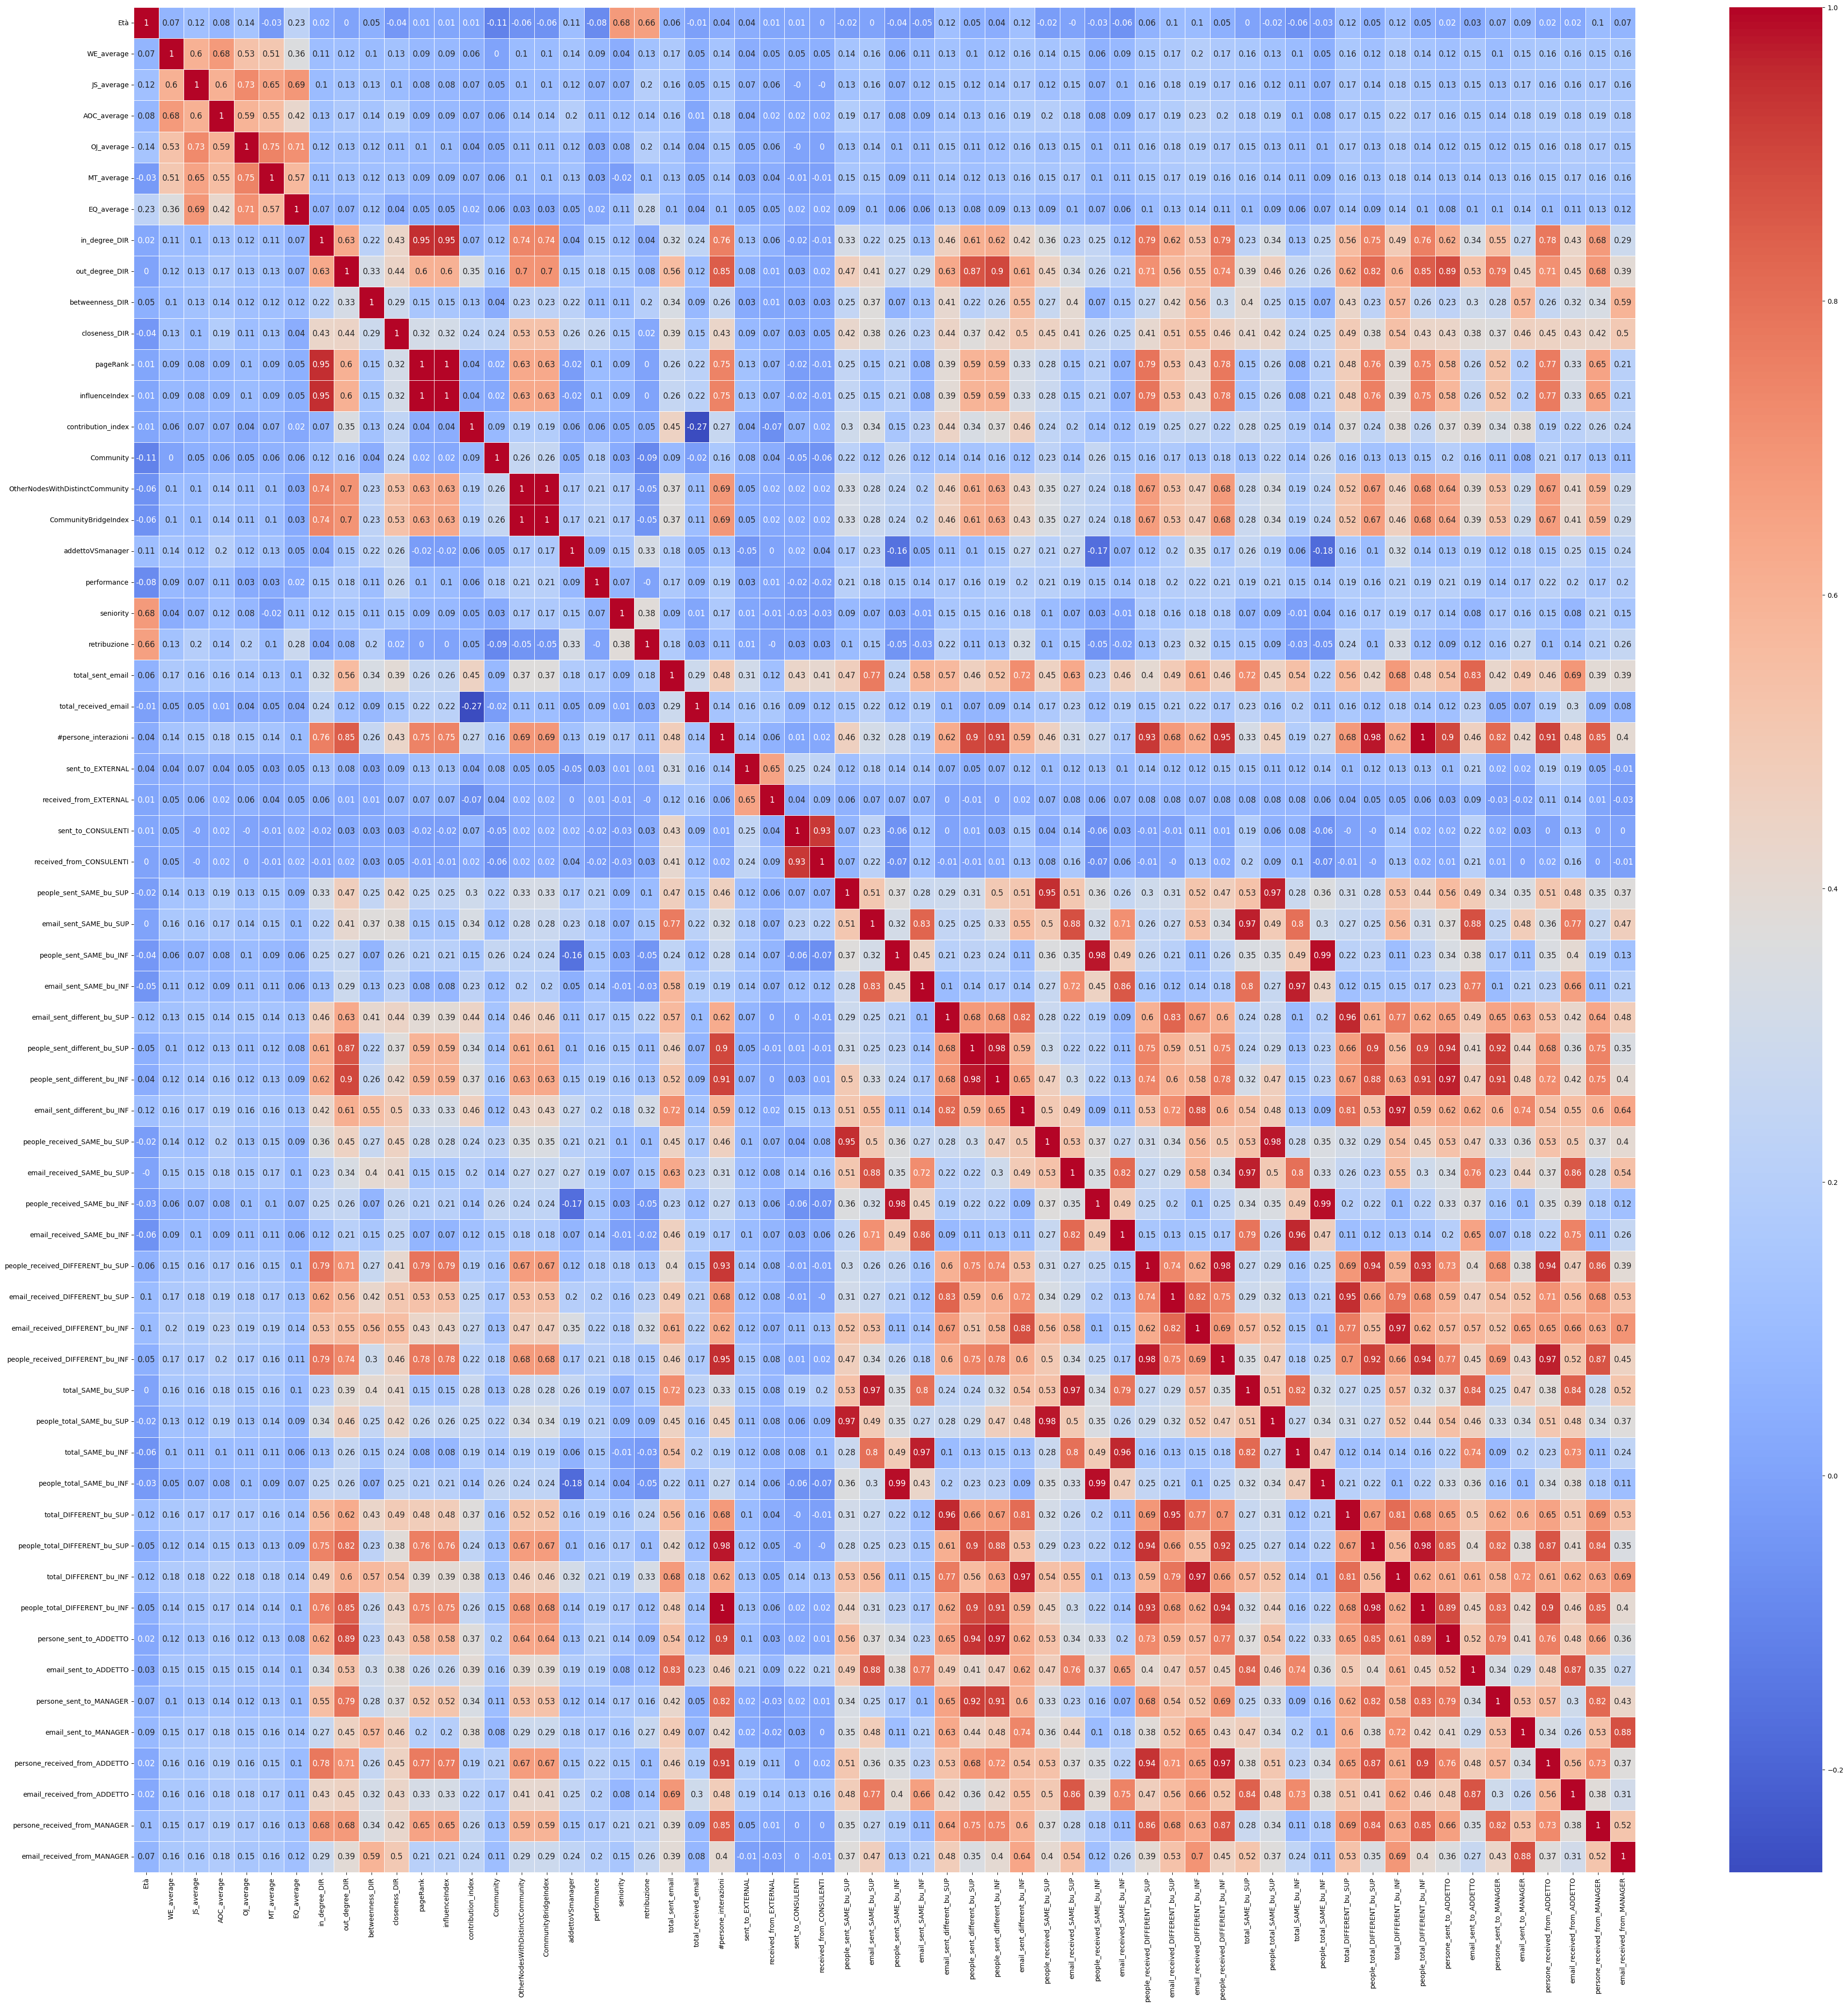

In [ ]:

# ////////////////////////////////////////////////// HEATMAP CON CORRELAZIONI TRA TUTTE LE VARIABILI \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\

# Vado a calcolare le correlazioni prendendo solamente i dati per cui le variabili psicologiche non sono tutte 0
# len(finale_features[finale_features['WE_average']!=0]) = 1489 // cioé vado a calcolare le correlazioni solamente per quelle peersone per cui ho dei risultati nella survey (se mancano delle ulteriori persone è perché ho droppato i nodi isolati nella network)
matrice_correlazioni= finale_features[finale_features['WE_average']!=0].corr()


#CALCOLO LE CORRELAZIONI tra tutte le feature che ho, anche quelle della network: vediamo che non sono correlatem questo perché le persone parlano per BU_sup
plt.figure(figsize = (50,50))
sns.heatmap(data=matrice_correlazioni.round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})



In [ ]:
# togli questo commento per avere le feature calcolate su tutte credem, non hai però le feature calcolate all'interno delle BU

"""
csv_file_path = '/content/gdrive/MyDrive/processati_email/df_features_TuttaCredem_Directed.csv'  # Specify the file path where you want to save the CSV
finale_features.to_csv(csv_file_path, index=False)

print("DataFrame df_email_completo saved to CSV successfully!")
"""

'\ncsv_file_path = \'/content/gdrive/MyDrive/processati_email/df_features_TuttaCredem_Directed.csv\'  # Specify the file path where you want to save the CSV\nfinale_features.to_csv(csv_file_path, index=False)\n\nprint("DataFrame df_email_completo saved to CSV successfully!")\n'

In [ ]:

print(finale_features.columns)

Index(['Età', 'Sesso', 'WE_average', 'JS_average', 'AOC_average', 'OJ_average',
       'MT_average', 'EQ_average', 'in_degree_DIR', 'out_degree_DIR',
       'betweenness_DIR', 'closeness_DIR', 'pageRank', 'influenceIndex',
       'contribution_index', 'Community', 'OtherNodesWithDistinctCommunity',
       'CommunityBridgeIndex', 'user_ID', 'addettoVSmanager', 'performance',
       'seniority', 'retribuzione', 'BU_sup', 'BU_inf', 'total_sent_email',
       'total_received_email', '#persone_interazioni', 'sent_to_EXTERNAL',
       'received_from_EXTERNAL', 'sent_to_CONSULENTI',
       'received_from_CONSULENTI', 'people_sent_SAME_bu_SUP',
       'email_sent_SAME_bu_SUP', 'people_sent_SAME_bu_INF',
       'email_sent_SAME_bu_INF', 'email_sent_different_bu_SUP',
       'people_sent_different_bu_SUP', 'people_sent_different_bu_INF',
       'email_sent_different_bu_INF', 'people_received_SAME_bu_SUP',
       'email_received_SAME_bu_SUP', 'people_received_SAME_bu_INF',
       'email_received_

In [ ]:
business_units = finale_features['BU_sup'].unique()  # Ottieni la lista delle business unit
persone_per_business_unit = []  # Inizializza una lista vuota per contenere i risultati

# Itero attraverso tutte le business unit
for unit in business_units:

    # Creo una lista con i nomi(codici identificativi) delle persone che appartengono alla business unit corrente(unit)
    persone = finale_features[finale_features['BU_sup'] == unit]['user_ID'].tolist()

    # Creo una lista di tuple con la forma ( BusinessUnit di appartenenza, lista persone che ci lavorano): lista formata da tuple dove ogni tupla ha la business unit e la lista di persone che ci lavorano;
    persone_per_business_unit.append((unit, persone))  # Aggiungi il risultato alla lista


In [ ]:
persone_per_business_unit = sorted(persone_per_business_unit, key=lambda x: x[0])


for business_unit, list_of_person in persone_per_business_unit:
  print(business_unit, " : ", len(list_of_person), " lista: ", list_of_person )





AMMIN  :  33  lista:  ['SGte1LvXSSGBLt0bC0SRuw', '_rUpSNvGQ0Oh6IwLMmVqmg', '4jz7ubbiTPm4MgI_0cOFYQ', 'fY5t8eOUSl-DYfmQK8KeNQ', '4fBPtVVESrO-BgenHbRrUA', 'gmeuJ6Z6TMqO40Xxny1MiQ', 'uFTnFdYeR4ibxZkXJu084g', 'IUJ4Ev5kT3WfaCRq_dwkxQ', 'zCRK9mrkSdiN2juaZzyNoQ', 'y54t4yp2Qh61jQOm75oZNA', 'Z5u4-g4qQU6m9IelR7A81Q', 'pXk6NNITSrGaOIcuFO3Xxw', 'UYPXk_FWRN6AUSrCxa8eAg', 'jzNJkLR7SHqH7TRZkpvwGw', 'euzToPSrT4Gm6youIk5vUg', '7Keno1qDS62QXlhHQL4MNg', '0sl19KNfTDWpl4HR1A9TUg', 'YC9afFaDR2S4u8d1cT0yIg', 'TCztk0XIRICJ4g0dLfzXGA', '3AqmFCMYSHi2xXdddjuByg', 'a0SedGU1RNmZD3JGUFzW6w', 'zHeVkakOReO_M9zJnnE4kQ', 'g2Xb_8H-Rt-1YILZ2jWfJQ', 'P5mhEyruSL6vLyZAECijxw', 'oA6xol3YRKq-VvUPNUuS8g', 'F_jF_duFTLiluC-pHUBfaQ', 'dU8yojZxRryl3pOMqPFKxg', '-H82nBCmRBm2QoP_FM7IeQ', 'bDNk8pe8RKeTEHLf9vlgfw', 'zpCHnzwZR-6ezNVlO9I5fQ', 'zOPYD2RXS6aSIgleNQadRQ', 'z7hUTL4uTW2Schivehc79A', 'Yd4z2qRLQTe1NGx1rkKB0g']
ANTRIC  :  11  lista:  ['t0mQvvSZQFK2w1vRcn3jkQ', '2fsZtHpUTZeAjYsMAUuuKw', '8TKevsI5T8SUnFjhkde9Jw', '1lgjD32iSou2wqi5

In [ ]:
df_temp= finale_features.copy()

df_temp.columns


Index(['Età', 'Sesso', 'WE_average', 'JS_average', 'AOC_average', 'OJ_average',
       'MT_average', 'EQ_average', 'in_degree_DIR', 'out_degree_DIR',
       'betweenness_DIR', 'closeness_DIR', 'pageRank', 'influenceIndex',
       'contribution_index', 'Community', 'OtherNodesWithDistinctCommunity',
       'CommunityBridgeIndex', 'user_ID', 'addettoVSmanager', 'performance',
       'seniority', 'retribuzione', 'BU_sup', 'BU_inf', 'total_sent_email',
       'total_received_email', '#persone_interazioni', 'sent_to_EXTERNAL',
       'received_from_EXTERNAL', 'sent_to_CONSULENTI',
       'received_from_CONSULENTI', 'people_sent_SAME_bu_SUP',
       'email_sent_SAME_bu_SUP', 'people_sent_SAME_bu_INF',
       'email_sent_SAME_bu_INF', 'email_sent_different_bu_SUP',
       'people_sent_different_bu_SUP', 'people_sent_different_bu_INF',
       'email_sent_different_bu_INF', 'people_received_SAME_bu_SUP',
       'email_received_SAME_bu_SUP', 'people_received_SAME_bu_INF',
       'email_received_

In [ ]:
print(df_temp.describe().to_string())

               Età   WE_average   JS_average  AOC_average   OJ_average   MT_average   EQ_average  in_degree_DIR  out_degree_DIR  betweenness_DIR  closeness_DIR     pageRank  influenceIndex  contribution_index    Community  OtherNodesWithDistinctCommunity  CommunityBridgeIndex  addettoVSmanager  performance    seniority  retribuzione  total_sent_email  total_received_email  #persone_interazioni  sent_to_EXTERNAL  received_from_EXTERNAL  sent_to_CONSULENTI  received_from_CONSULENTI  people_sent_SAME_bu_SUP  email_sent_SAME_bu_SUP  people_sent_SAME_bu_INF  email_sent_SAME_bu_INF  email_sent_different_bu_SUP  people_sent_different_bu_SUP  people_sent_different_bu_INF  email_sent_different_bu_INF  people_received_SAME_bu_SUP  email_received_SAME_bu_SUP  people_received_SAME_bu_INF  email_received_SAME_bu_INF  people_received_DIFFERENT_bu_SUP  email_received_DIFFERENT_bu_SUP  email_received_DIFFERENT_bu_INF  people_received_DIFFERENT_bu_INF  total_SAME_bu_SUP  people_total_SAME_bu_SUP  total

In [ ]:
print( len(df_temp[df_temp['betweenness_DIR']!=0 ] ))

1415


In [ ]:

# ci sono 62 BU superiori
from IPython.display import display
i=0

for business_unit, list_of_person in persone_per_business_unit:
    bu= business_unit
    list_of_person = list_of_person

    # attualmente i pesi sono interi, quindi per la betweenness devi girarli
    grafo_bu = G_directed_weighted_new.subgraph(list_of_person)

    #//////////////////////////////////////// CALCOLO LE METRICHE DI CENTRALITA' \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\

    in_degree_centrality = nx.in_degree_centrality(grafo_bu) # gia normalizzata
    out_degree_centrality = nx.out_degree_centrality(grafo_bu) # gia normalizzata
    betweenness_centrality_weight = nx.betweenness_centrality(grafo_bu, normalized=True, weight='weight')
    #page_Rank = nx.pagerank(grafo_bu, alpha=0.85, personalization=None, max_iter=100, tol=0.001)
    closeness_centrality_weight = nx.closeness_centrality(grafo_bu, distance='weight')



    # CONTRIBUTION INDEX
    # NORMALIZED: at the denominator we are subtracting by the total of the email sent, so it is already normalized from 0 to 1
    ## since networkX doesn't implement the "contribution index", I calculated it manually
    ## CI= (#messages_sent - #messages_received) / (#messages_sent + #messages_received)

    # calcolo il CI direttamente dopo!

    #////////////////////////////////////////// CREO IL DATAFRAME CHE UTILIZZERò POI PER LE CORRELAZIONI \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\

    max_closeness = max(closeness_centrality_weight.values())

    if max_closeness==0: max_closeness=1

    for idUser in list_of_person:

          try:
            # Update in-degree centrality
            df_temp.loc[df_temp['user_ID'] == idUser, 'in_degree_BU'] = in_degree_centrality[idUser]

            # Update out-degree centrality
            df_temp.loc[df_temp['user_ID'] == idUser, 'out_degree_BU'] = out_degree_centrality[idUser]

            # Update betweenness centrality
            df_temp.loc[df_temp['user_ID'] == idUser, 'betweenness_BU'] = betweenness_centrality_weight[idUser]


            # Update closeness centrality
            df_temp.loc[df_temp['user_ID'] == idUser, 'closeness_BU'] = closeness_centrality_weight[idUser]/max_closeness
            #print(idUser, '::::', bu, ' ::: ', df_temp.loc[df_temp['user_ID'] == idUser, 'closeness_BU'])

            #df_temp.loc[df_temp['user_ID'] == idUser, 'influenceIndex_BU'] = df_idUser_pageRank[idUser]


            # Update Contribution Index

            messages_sent = df_features.loc[df_features['user_ID'] == idUser, 'total_sent_email'].values[0]
            messages_received = df_features.loc[df_features['user_ID'] == idUser, 'total_received_email'].values[0]
            ci_user = (messages_sent - messages_received) / (messages_sent + messages_received)

            df_temp.loc[df_temp['user_ID'] == idUser, 'contribution_index'] = ci_user


          except KeyError:
              print(f"KeyError occurred for idUser: {idUser}")



df_temp = df_temp.fillna(0)
print(df_temp.head(2).to_string())

<ipython-input-211-5038f06f63be>:59: RuntimeWarning: invalid value encountered in long_scalars
  ci_user = (messages_sent - messages_received) / (messages_sent + messages_received)


    Età Sesso  WE_average  JS_average  AOC_average  OJ_average  MT_average  EQ_average  in_degree_DIR  out_degree_DIR  betweenness_DIR  closeness_DIR  pageRank  influenceIndex  contribution_index  Community  OtherNodesWithDistinctCommunity  CommunityBridgeIndex                 user_ID  addettoVSmanager  performance  seniority  retribuzione BU_sup BU_inf  total_sent_email  total_received_email  #persone_interazioni  sent_to_EXTERNAL  received_from_EXTERNAL  sent_to_CONSULENTI  received_from_CONSULENTI  people_sent_SAME_bu_SUP  email_sent_SAME_bu_SUP  people_sent_SAME_bu_INF  email_sent_SAME_bu_INF  email_sent_different_bu_SUP  people_sent_different_bu_SUP  people_sent_different_bu_INF  email_sent_different_bu_INF  people_received_SAME_bu_SUP  email_received_SAME_bu_SUP  people_received_SAME_bu_INF  email_received_SAME_bu_INF  people_received_DIFFERENT_bu_SUP  email_received_DIFFERENT_bu_SUP  email_received_DIFFERENT_bu_INF  people_received_DIFFERENT_bu_INF  total_SAME_bu_SUP  people_tot

In [ ]:
print(len(df_temp[ df_temp['betweenness_BU']!=0 & ~(df_temp['betweenness_BU'].isna()) ]))

print(len(df_temp[ df_temp['closeness_BU']!=0 & ~(df_temp['closeness_BU'].isna()) ]))

print(len(df_temp[ df_temp['out_degree_BU']!=0 & ~(df_temp['out_degree_BU'].isna()) ]))

print(len(df_temp[ df_temp['in_degree_BU']!=0 & ~(df_temp['in_degree_BU'].isna()) ]))

print()

print(len(df_temp[ df_temp['contribution_index']!=0 & ~(df_temp['contribution_index'].isna()) ]))

print()


print(len(df_temp[ df_temp['betweenness_DIR']!=0 & ~(df_temp['betweenness_DIR'].isna()) ]))

print(len(df_temp[ df_temp['closeness_DIR']!=0 & ~(df_temp['closeness_DIR'].isna()) ]))

print(len(df_temp[ df_temp['out_degree_DIR']!=0 & ~(df_temp['out_degree_DIR'].isna()) ]))



1128
2018
2014
2018

2027

1415
2027
2021


In [ ]:
df_temp = df_temp.fillna(0)

print(len(df_temp[~(df_temp['betweenness_BU'].isna()) ]))

print(len(df_temp[~(df_temp['closeness_BU'].isna()) ]))

print(len(df_temp[ ~(df_temp['out_degree_BU'].isna()) ]))

print(len(df_temp[~(df_temp['in_degree_BU'].isna()) ]))

print()

print(len(df_temp[  ~(df_temp['contribution_index'].isna()) ]))

print()


print(len(df_temp[ ~(df_temp['betweenness_DIR'].isna()) ]))

print(len(df_temp[ ~(df_temp['closeness_DIR'].isna()) ]))

print(len(df_temp[ ~(df_temp['out_degree_DIR'].isna()) ]))



2027
2027
2027
2027

2027

2027
2027
2027


In [ ]:
print(df_temp.describe().to_string())

               Età   WE_average   JS_average  AOC_average   OJ_average   MT_average   EQ_average  in_degree_DIR  out_degree_DIR  betweenness_DIR  closeness_DIR     pageRank  influenceIndex  contribution_index    Community  OtherNodesWithDistinctCommunity  CommunityBridgeIndex  addettoVSmanager  performance    seniority  retribuzione  total_sent_email  total_received_email  #persone_interazioni  sent_to_EXTERNAL  received_from_EXTERNAL  sent_to_CONSULENTI  received_from_CONSULENTI  people_sent_SAME_bu_SUP  email_sent_SAME_bu_SUP  people_sent_SAME_bu_INF  email_sent_SAME_bu_INF  email_sent_different_bu_SUP  people_sent_different_bu_SUP  people_sent_different_bu_INF  email_sent_different_bu_INF  people_received_SAME_bu_SUP  email_received_SAME_bu_SUP  people_received_SAME_bu_INF  email_received_SAME_bu_INF  people_received_DIFFERENT_bu_SUP  email_received_DIFFERENT_bu_SUP  email_received_DIFFERENT_bu_INF  people_received_DIFFERENT_bu_INF  total_SAME_bu_SUP  people_total_SAME_bu_SUP  total

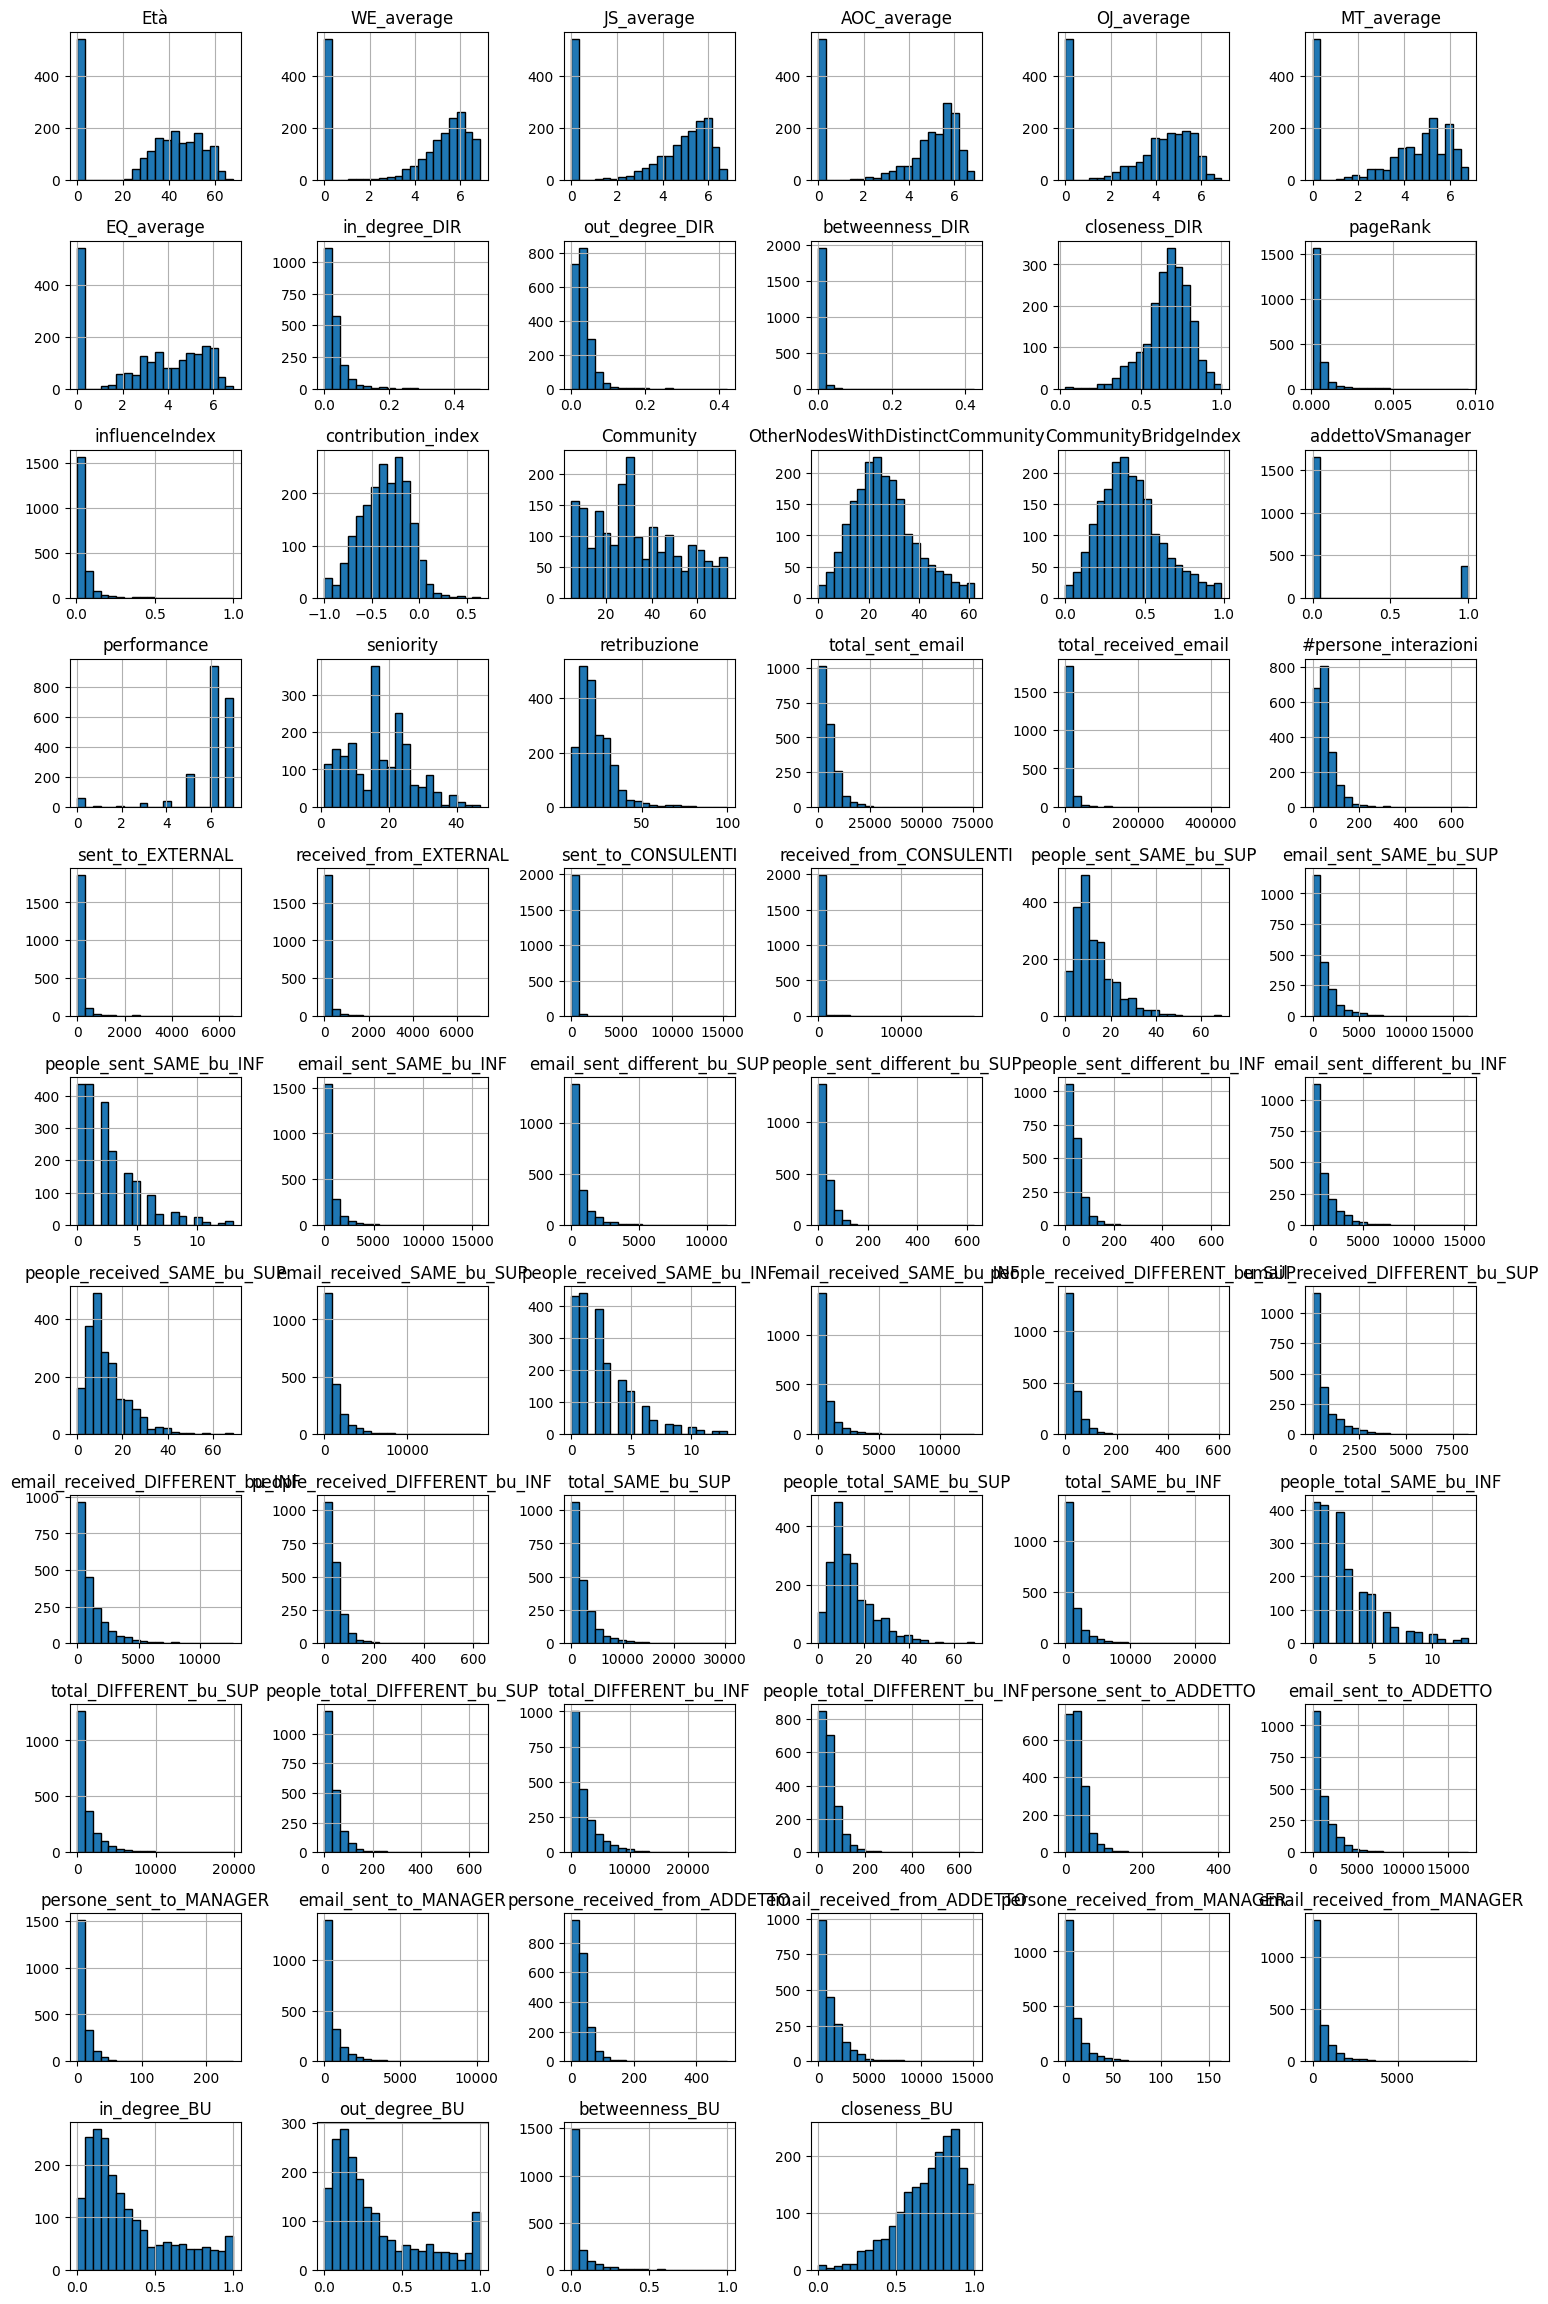

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Supponiamo che 'df_temp' sia il tuo dataframe
# Carica i dati nel dataframe o sostituisci questa riga con il tuo metodo di caricamento dati

# Plotta gli istogrammi con distanza maggiore tra i grafici
df_temp.hist(layout=(12, 6), figsize=(15, 25), bins=20, edgecolor='black')
plt.tight_layout()  # Ottimizza lo spaziamento tra i grafici
plt.show()


In [ ]:
# togli questo commento per avere le feature calcolate su tutte credem, non hai però le feature calcolate all'interno delle BU


csv_file_path = '/content/gdrive/MyDrive/processati_email/df_features3_DIRECTED_completo.csv'  #  file path where you want to save the CSV
df_temp.to_csv(csv_file_path, index=False)

print("DataFrame df_email_completo saved to CSV successfully!")


DataFrame df_email_completo saved to CSV successfully!
